## Imports

In [5]:
import pandas as pd
import numpy as np
import bz2
from bs4 import BeautifulSoup
import re
import html
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import XMLParsedAsHTMLWarning
from transformers import BertTokenizer
import torch
import torch as pt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from collections import Counter
import gc
import json
import warnings
warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

In [2]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect() 

In [3]:
gc.collect()
torch.cuda.empty_cache()

## Load Data  

In [3]:
with bz2.open("newsSpace.bz2", "rt") as f:
    for i in range(10):
        print(f.readline())

Yahoo Business	http://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/column_stocks_week_dc	Wall St. Pullback Reflects Tech Blowout (Reuters)	none	Business	Reuters - Wall Street's long-playing drama,\

"Waiting for Google," is about to reach its final act, but its\

stock market debut is ending up as more of a nostalgia event\

than the catalyst for a new era.	5	0000-00-00 00:00:00	\N

Yahoo Business	http://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/markets_bears_dc	Wall St. Bears Claw Back Into the Black (Reuters)	none	Business	Reuters - Short-sellers, Wall Street's dwindling\

band of ultra-cynics, are seeing green again.	5	0000-00-00 00:00:00	\N

Yahoo Business	http://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/column_mergers_dc	Carlyle Looks Toward Commercial Aerospace (Reuters)	none	Business	Reuters -

In [4]:
with bz2.open("newsSpace.bz2", "rt", encoding="latin1", errors="replace") as f:
    for i in range(50):
        line = f.readline()
        print(repr(line))

"Yahoo Business\thttp://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/column_stocks_week_dc\tWall St. Pullback Reflects Tech Blowout (Reuters)\tnone\tBusiness\tReuters - Wall Street's long-playing drama,\\\n"
'"Waiting for Google," is about to reach its final act, but its\\\n'
'stock market debut is ending up as more of a nostalgia event\\\n'
'than the catalyst for a new era.\t5\t0000-00-00 00:00:00\t\\N\n'
"Yahoo Business\thttp://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/markets_bears_dc\tWall St. Bears Claw Back Into the Black (Reuters)\tnone\tBusiness\tReuters - Short-sellers, Wall Street's dwindling\\\n"
'band of ultra-cynics, are seeing green again.\t5\t0000-00-00 00:00:00\t\\N\n'
'Yahoo Business\thttp://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/column_mergers_dc\tCarlyle Looks Toward Commercial 

In [5]:
def extract_articles(file_path):
    current_record = []
    with bz2.open(file_path, "rt", encoding="latin1", errors="replace") as f:
        for line in f:
            current_record.append(line)
            if line.endswith("\t\\N\n"):
                yield "".join(current_record)
                current_record = []

In [7]:
def parse_article_block(article_block):
    collapsed = article_block.replace("\n", " ").strip()
    fields = collapsed.split("\t")

    expected_fields = 9
    if len(fields) < expected_fields:
        fields += [None] * (expected_fields - len(fields))
    elif len(fields) > expected_fields:
        fields = fields[:expected_fields - 1] + [' '.join(fields[expected_fields - 1:])]

    return {
        "source": fields[0] or "Unknown Source",
        "url": fields[1] or "No URL",
        "title": fields[2] or "Untitled",
        "subtitle": fields[3] if fields[3] and fields[3].lower() != "none" else None,
        "category": fields[4] or "Uncategorized",
        "content": fields[5] or "",
        "score": int(fields[6]) if fields[6] and fields[6].isdigit() else None,
        "published_at": fields[7] if fields[7] and fields[7] != "0000-00-00 00:00:00" else None,
        "extra": None if fields[8] in [r"\N", None] else fields[8]
    }

In [8]:
def load_articles(file_path):
    articles = []
    for block in extract_articles(file_path):
        article = parse_article_block(block)
        articles.append(article)
    return articles

In [11]:
articles = []
articles = load_articles("newsSpace.bz2")

In [12]:
articles[:10]

[{'source': 'Yahoo Business',
  'url': 'http://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/column_stocks_week_dc',
  'title': 'Wall St. Pullback Reflects Tech Blowout (Reuters)',
  'subtitle': None,
  'category': 'Business',
  'content': 'Reuters - Wall Street\'s long-playing drama,\\ "Waiting for Google," is about to reach its final act, but its\\ stock market debut is ending up as more of a nostalgia event\\ than the catalyst for a new era.',
  'score': 5,
  'published_at': None,
  'extra': None},
 {'source': 'Yahoo Business',
  'url': 'http://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/markets_bears_dc',
  'title': 'Wall St. Bears Claw Back Into the Black (Reuters)',
  'subtitle': None,
  'category': 'Business',
  'content': "Reuters - Short-sellers, Wall Street's dwindling\\ band of ultra-cynics, are seeing green again.",
  'score': 5,
  'published_at': None,


In [13]:
df = pd.DataFrame(articles)
df.to_csv("articles.csv", index=False)

In [14]:
df.head()

,source,url,title,subtitle,category,content,score,published_at,extra
0,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Wall St. Pullback Reflects Tech Blowout (Reuters),None,Business,"Reuters - Wall Street's long-playing drama,\ ""...",5.0,None,None
1,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Wall St. Bears Claw Back Into the Black (Reuters),None,Business,"Reuters - Short-sellers, Wall Street's dwindli...",5.0,None,None
2,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Carlyle Looks Toward Commercial Aerospace (Reu...,None,Business,Reuters - Private investment firm Carlyle Grou...,5.0,None,None
3,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Oil and Economy Cloud Stocks' Outlook (Reuters),None,Business,Reuters - Soaring crude prices plus worries\ a...,5.0,None,None
4,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Iraq Halts Oil Exports from Main Southern Pipe...,None,Business,Reuters - Authorities have halted oil export\ ...,5.0,None,None


## Data Cleaning

In [2]:
df = pd.read_csv("articles.csv")

In [19]:
def clean(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = html.unescape(text)
    text = text.replace("/", " ")
    text = unicodedata.normalize("NFKD", text)
    text = text.encode("ascii", "ignore").decode("ascii")
    text = re.sub(r"[^a-zA-Z0-9.,!?;:'\"()\-\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    return text if text else None

### Focus on the "content" column

In [4]:
print(f"Number of articles with 'none' content: {(df['content'] == "none").sum()}")
print(f"Number of articles with missing content: {(df['content'].isna()).sum()}")
print(f"Number of articles with no content at all: {(df['content'] == "").sum()}")
print(f"Number of rows inside the dataframe: {len(df)}")

Number of articles with 'none' content: 4469
Number of articles with missing content: 22
Number of articles with no content at all: 0
Number of rows inside the dataframe: 1281103


In [10]:
df = df[~df['content'].isin(["none", "\\N", ""])]
df = df.dropna(subset=['content'])
df['content'] = df['content'].apply(clean)
df = df.dropna(subset=['content'])

In [11]:
df['content_length'] = df['content'].astype(str).apply(len)
stats = df['content_length'].describe()
print(stats)

count    1.238234e+06
mean     1.803667e+02
std      2.081738e+02
min      1.000000e+00
25%      1.140000e+02
50%      1.730000e+02
75%      2.140000e+02
max      2.257200e+04
Name: content_length, dtype: float64


In [13]:
df[df['content_length'] == df['content_length'].min()]['content'].values[0]

'd'

In [12]:
df[df['content_length'] == df['content_length'].max()]['content'].values[0]

'Imagine how different the tech industry might have been had Gary Kildall accepted IBM\'s offer, back in 1980, to license his computer operating system for a top-secret project. CPM would have been the OS that shipped with the original IBM PC, and the world might never have heard the name of Kildall\'s competitor, who eventually accepted the contract: a Mr. Bill Gates. For all the amazing advances that the computing industry has brought us over the years, some of its most pivotal moments are memorable for all the wrong reasons. Not every idea can be a winner, and not even Microsoft can avoid every misstep. But as they say, those who forget history are doomed to repeat it -- and then again, others just keep screwing up. In the interest of schadenfreude, then, here is a look back at the last 20 years\' worth of blunders, fumbles, also-rans, and downright disasters that you may have forgotten about -- or wish you could.Top tech flops Nos. 21-25: PS2, VR, compression wars, ... Top tech flo

In [18]:
Q1 = df['content_length'].quantile(0.25)
Q3 = df['content_length'].quantile(0.75)
print(f"Q1 = {Q1}")
print(f"Q3 = {Q3}")

IQR = Q3 - Q1
print(f"IQR = {IQR}")

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Lower Bound = {lower_bound}")
print(f"Upper Bound = {upper_bound}")

Q1 = 114.0
Q3 = 214.0
IQR = 100.0
Lower Bound = -36.0
Upper Bound = 364.0


In [20]:
df = df[(df['content_length'] >= 20) & (df['content_length'] <= upper_bound)]

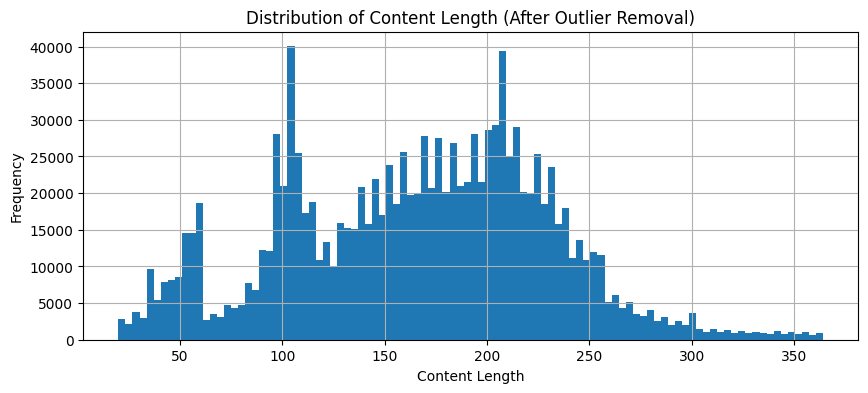

In [21]:
plt.figure(figsize=(10, 4))
df['content_length'].hist(bins=100)
plt.title("Distribution of Content Length (After Outlier Removal)")
plt.xlabel("Content Length")
plt.ylabel("Frequency")
plt.show()

### Focus on the "category" column

In [39]:
df['category'] = df['category'].str.lower().str.strip()

In [45]:
print(len(df['category'].value_counts(dropna=False)))
print(df['category'].value_counts(dropna=False).head(15))

4263
category
world                        183341
sci/tech                     144607
entertainment                135847
business                     132606
italia                       129824
sports                       116490
top news                      99736
europe                        90033
top stories                   61577
u.s.                          47049
health                        42387
software and developement     13223
music feeds                    7401
toons                           422
ryder cup - live!                 4
Name: count, dtype: int64


In [47]:
top_categories = df['category'].value_counts().head(14).index.tolist()

In [53]:
df['category'] = df['category'].replace({
    'top news': 'world',
    'top stories': 'world',
    'u.s.': 'world',
    'italia': 'world',
    'europe': 'world', 
    'software and developement': 'sci/tech',
    'music feeds': 'entertainment',
    'toons': 'entertainment'
})

In [55]:
print(len(df['category'].value_counts(dropna=False)))
print(df['category'].value_counts(dropna=False).head(15))

4255
category
world                                           611560
sci/tech                                        157830
entertainment                                   143670
business                                        132606
sports                                          116490
health                                           42387
ryder cup - live!                                    4
russia seizes $20bn gas project                      2
'once you have eaten them you get obsessed'          2
stingray kills 'crocodile hunter'                    2
figures show rise in violent crime                   2
firms face compulsory carbon quotas                  2
bush sworn in for second term                        2
'i knew we were going  to get attacked ... '         2
downloads to hit top 40                              2
Name: count, dtype: int64


In [56]:
main_categories = ['world', 'sci/tech', 'entertainment', 'business', 'sports', 'health']
df_other = df[~df['category'].isin(main_categories)]

In [58]:
print(df_other['category'].value_counts())
df_other.to_csv("other_categories.csv", index=False)

category
ryder cup - live!                              4
'once you have eaten them you get obsessed'    2
stingray kills 'crocodile hunter'              2
figures show rise in violent crime             2
firms face compulsory carbon quotas            2
                                              ..
interview: sally vincent meets rob brydon      1
wedded to an ideal                             1
tsunami kills thousands                        1
lady and the lamp                              1
life after the wave                            1
Name: count, Length: 4249, dtype: int64


In [59]:
df = df[df['category'].isin(main_categories)]

In [27]:
df['category'].value_counts(dropna=False)

category
world            611528
sci/tech         157826
entertainment    143670
business         132598
sports           116488
health            42387
Name: count, dtype: int64

#### Discussion regarding the imbalance of the categories
<blockquote>The categories are highly imbalanced leading to poor generalization for the minority categories(e.g. health), and misleading performance metrics.</blockquote>
<blockquote>One solution might be to downsample the world category or simply assigning different weights for the categories in the loss function.</blockquote>

### Focus on the "title" column

In [66]:
df['title'] = df['title'].fillna("")
df['title'] = df['title'].apply(clean)
df['title'] = df['title'].fillna("")

In [69]:
print(f"Number of articles with 'none' content: {(df['title'] == "none").sum()}")
print(f"Number of articles with missing content: {(df['title'].isna()).sum()}")
print(f"Number of articles with no content at all: {(df['title'] == "").sum()}")
print(f"Number of rows inside the dataframe: {len(df)}")

Number of articles with 'none' content: 0
Number of articles with missing content: 0
Number of articles with no content at all: 46
Number of rows inside the dataframe: 1204543


In [70]:
df = df[df['title'] != ""]

### Focus on the "source" column

In [79]:
df['source'] = df['source'].fillna("")
df['source'] = df['source'].apply(clean)
df['source'] = df['source'].fillna("")

In [80]:
print(f"Number of articles with 'none' content: {(df['source'] == "none").sum()}")
print(f"Number of articles with missing content: {(df['source'].isna()).sum()}")
print(f"Number of articles with no content at all: {(df['source'] == "").sum()}")
print(f"Number of rows inside the dataframe: {len(df)}")

Number of articles with 'none' content: 0
Number of articles with missing content: 0
Number of articles with no content at all: 0
Number of rows inside the dataframe: 1204497


In [81]:
df = df[df['source'] != ""]

### Drop irelevant columns

In [7]:
df = df.drop(columns=['subtitle', 'published_at', 'extra', 'url'])

### Save Modifications

In [82]:
df.to_csv("articles_cleaned.csv", index=False)

## Read Cleaned Data

In [2]:
df = pd.read_csv("articles_cleaned.csv")

In [3]:
df.head()

,source,title,category,content,score,content_length
0,Yahoo Business,Wall St. Pullback Reflects Tech Blowout (Reuters),business,"Reuters - Wall Street's long-playing drama, ""W...",5.0,200
1,Yahoo Business,Wall St. Bears Claw Back Into the Black (Reuters),business,"Reuters - Short-sellers, Wall Street's dwindli...",5.0,94
2,Yahoo Business,Carlyle Looks Toward Commercial Aerospace (Reu...,business,Reuters - Private investment firm Carlyle Grou...,5.0,214
3,Yahoo Business,Oil and Economy Cloud Stocks' Outlook (Reuters),business,Reuters - Soaring crude prices plus worries ab...,5.0,184
4,Yahoo Business,Iraq Halts Oil Exports from Main Southern Pipe...,business,Reuters - Authorities have halted oil export f...,5.0,195


### Downsample the "world" category to balance the dataset and prepare labels for categories

In [29]:
world_sample = df[df['category'] == 'world'].sample(n=130000, random_state=42)
other_categories = df[df['category'] != 'world']
df_balanced = pd.concat([world_sample, other_categories])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['category'].value_counts())

category
sci/tech         157826
entertainment    143670
business         132598
world            130000
sports           116488
health            42387
Name: count, dtype: int64


In [25]:
label_to_id = {
    'world': 0,
    'sci/tech': 1,
    'entertainment': 2,
    'business': 3,
    'sports': 4,
    'health': 5
}

label_map = {v: k for k, v in label_to_id.items()}
print(f"This is the label mapping:{label_map}")

with open("label_mappings.json", "w") as f:
    json.dump({
        "label_to_id": label_to_id,
        "label_map": label_map
    }, f)

df_balanced['label_id'] = df_balanced['category'].map(label_to_id)

This is the label mapping:{0: 'world', 1: 'sci/tech', 2: 'entertainment', 3: 'business', 4: 'sports', 5: 'health'}


In [19]:
df_balanced.head()

,source,title,category,content,score,content_length,num_tokens,label_id
0,Boston Globe,Shell's game: Take chance,sports,When the former coach of the Oakland Raiders t...,5.0,217,42,4
1,Yahoo Sports,Leafs deny Brodeur his 40th victory (AP),sports,AP - The Toronto Maple Leafs didn't beat the N...,5.0,166,41,4
2,The Motley Fool,Cheer Up or Go Broke,business,It turns out that misery is not miserly.,5.0,40,12,3
3,Reuters Business,"United, Continental in early merger talks: sou...",business,NEW YORKPHILADELPHIA (Reuters) - United Airlin...,5.0,242,50,3
4,Yahoo Tech,Changes fail to halt 3's legal pursuit (FT.com),sci/tech,"FT.com - 3, the mobile phone operator, has vow...",5.0,171,40,1


In [26]:
df_balanced.to_csv("balanced_articles.csv", index=False)

## BERT Tokenizer

### Analysis on the appropriate max_length

In [5]:
from transformers import BertTokenizer
import torch

In [6]:
sentences = df['content'].dropna().sample(4, random_state=42).tolist()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
encoded_inputs = tokenizer(sentences, return_tensors=None, padding=False, truncation=False)
print("Encoded Inputs:", encoded_inputs)

decoded_tokens = tokenizer.decode(encoded_inputs['input_ids'][0])
print("\nDecoded Tokens (first sentence):", decoded_tokens)

Encoded Inputs: {'input_ids': [[101, 21358, 2361, 1011, 3060, 2865, 6591, 2020, 2358, 3089, 6455, 2000, 13984, 10411, 1005, 1055, 2231, 1998, 2049, 8443, 22277, 2015, 2000, 5993, 1037, 2933, 2000, 2203, 1996, 6114, 1997, 18243, 27942, 1005, 1055, 19337, 5243, 9077, 5596, 9272, 1998, 2132, 2125, 1996, 3891, 1997, 7823, 2121, 4895, 2895, 1012, 102], [101, 4542, 1999, 1996, 2103, 1011, 4958, 2011, 2303, 1011, 5213, 102], [101, 1037, 3528, 1997, 2417, 9175, 9735, 2253, 2006, 5096, 7483, 1010, 1998, 2085, 1996, 6984, 29008, 2031, 1996, 5356, 4834, 2000, 2128, 1011, 3696, 7707, 10337, 1010, 4463, 13075, 4221, 2243, 2096, 2192, 1011, 8130, 1037, 25359, 1012, 102], [101, 5365, 4835, 2253, 2000, 7573, 2976, 2457, 9857, 1010, 15242, 2048, 20543, 2114, 2570, 13294, 3609, 26335, 2015, 6878, 1997, 19948, 4691, 11304, 2094, 4809, 1997, 5691, 2058, 1996, 4274, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [15]:
print("\nToken IDs (first sentence):", encoded_inputs['input_ids'][0])
print("Attention Mask (first sentence):", encoded_inputs['attention_mask'][0])


Token IDs (first sentence): [101, 21358, 2361, 1011, 3060, 2865, 6591, 2020, 2358, 3089, 6455, 2000, 13984, 10411, 1005, 1055, 2231, 1998, 2049, 8443, 22277, 2015, 2000, 5993, 1037, 2933, 2000, 2203, 1996, 6114, 1997, 18243, 27942, 1005, 1055, 19337, 5243, 9077, 5596, 9272, 1998, 2132, 2125, 1996, 3891, 1997, 7823, 2121, 4895, 2895, 1012, 102]
Attention Mask (first sentence): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [16]:
encoding = tokenizer(
    sentences,
    max_length=64,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)

print("\nToken IDs (first sentence):", encoding['input_ids'][0])
print("Attention Mask (first sentence):", encoding['attention_mask'][0])


Token IDs (first sentence): tensor([  101, 21358,  2361,  1011,  3060,  2865,  6591,  2020,  2358,  3089,
         6455,  2000, 13984, 10411,  1005,  1055,  2231,  1998,  2049,  8443,
        22277,  2015,  2000,  5993,  1037,  2933,  2000,  2203,  1996,  6114,
         1997, 18243, 27942,  1005,  1055, 19337,  5243,  9077,  5596,  9272,
         1998,  2132,  2125,  1996,  3891,  1997,  7823,  2121,  4895,  2895,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Attention Mask (first sentence): tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [17]:
decoded_tokens = tokenizer.decode(encoding['input_ids'][0], skip_special_tokens=True)
print("\nDecoded Tokens (after truncation):", decoded_tokens)


Decoded Tokens (after truncation): afp - african mediators were striving to persuade sudan's government and its rebel foes to agree a plan to end the suffering of darfur's beleaguered civilians and head off the risk of tougher un action.


In [25]:
batch = tokenizer(
    df['content'].astype(str).tolist(), 
    padding=False,
    truncation=False,
    return_length=True
)

df['num_tokens'] = batch['length']

In [26]:
df['num_tokens'].describe()

count    1.204497e+06
mean     3.810263e+01
std      1.452425e+01
min      4.000000e+00
25%      2.800000e+01
50%      3.800000e+01
75%      4.600000e+01
max      1.820000e+02
Name: num_tokens, dtype: float64

#### Discussion regarding the max_length parameter for tokenizer

<blockquote>I've computed the number of tokens for my <code>content</code> column, and I've observed that the majority of the rows have 46 tokens, therefore, I can use both <code>max_length = 64 or 128</code>.</blockquote>
<blockquote>If I use <code>max_length = 64</code>, I do not truncate too much data, and if I use <code>max_length = 128</code>, I cover the entire dataset.</blockquote>

## Proposed Architecture

In [7]:
class TransformerBlock(nn.Module):
    def __init__(self, embeddings_dimension, heads, ff_hidden_dim, dropout):
        super().__init__()
        self.attention = nn.MultiheadAttention(embeddings_dimension, heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embeddings_dimension)
        self.ff = nn.Sequential(
            nn.Linear(embeddings_dimension, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, embeddings_dimension)
        )
        self.norm2 = nn.LayerNorm(embeddings_dimension)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask):
        key_padding_mask = (attn_mask == 0) 
        attn_output, _ = self.attention(x, x, x, key_padding_mask=key_padding_mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [8]:
class NewsClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes=6, embed_dim=128, num_heads=4,
                 num_layers=4, ff_hidden_dim=256, max_len=128, dropout=0.1):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb = nn.Embedding(max_len, embed_dim)

        self.layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_hidden_dim, dropout)
            for _ in range(num_layers)
        ])

        self.cls_head = nn.Linear(embed_dim, num_classes)  

    def forward(self, input_ids, attn_mask):
        batch_size, seq_len = input_ids.size()
        positions = pt.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, seq_len)

        x = self.token_emb(input_ids) + self.pos_emb(positions)

        for layer in self.layers:
            x = layer(x, attn_mask)

        cls_token = x[:, 0]  
        return self.cls_head(cls_token)  

## Dataset & Dataloader

In [9]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': pt.tensor(label, dtype=pt.long)
        }

In [12]:
df_balanced = pd.read_csv("balanced_articles.csv")

texts = df_balanced['content'].values
labels = df_balanced['label_id'].values

train_texts, val_test_texts, train_labels, val_test_labels = train_test_split(texts, labels, test_size=0.4, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(val_test_texts, val_test_labels, test_size=0.5, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = NewsDataset(train_texts, train_labels, tokenizer)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

### Some visualizations

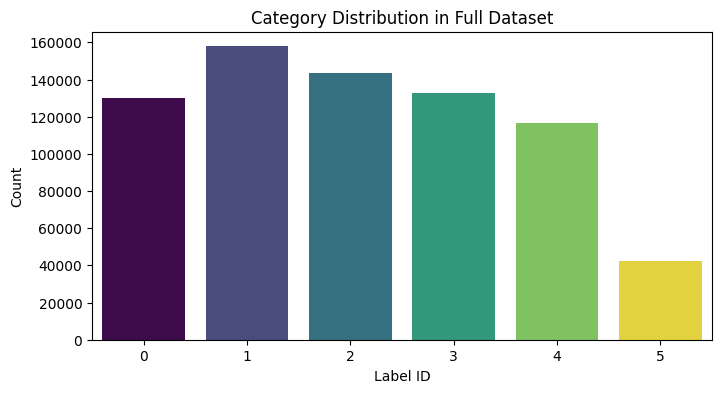

In [12]:
category_counts = df_balanced['label_id'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, palette="viridis", legend=False)
plt.title("Category Distribution in Full Dataset")
plt.xlabel("Label ID")
plt.ylabel("Count")
plt.show()

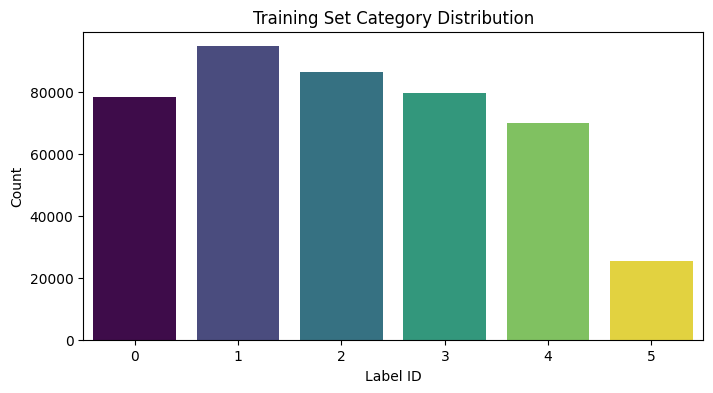

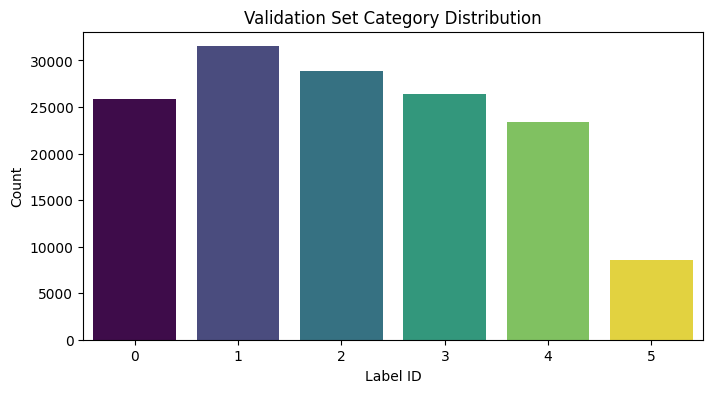

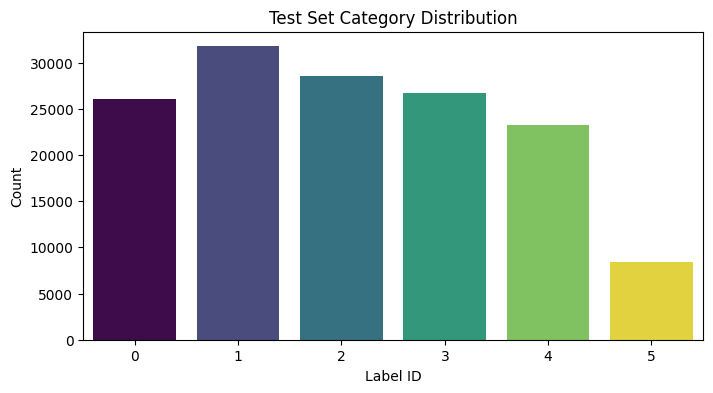

In [14]:
def plot_split_distribution(split_labels, title):
    counter = Counter(split_labels)
    ids = sorted(counter.keys())
    counts = [counter[i] for i in ids]

    plt.figure(figsize=(8, 4))
    sns.barplot(x=ids, y=counts, hue=category_counts.index, palette="viridis", legend=False)
    plt.title(title)
    plt.xlabel("Label ID")
    plt.ylabel("Count")
    plt.show()

plot_split_distribution(train_labels, "Training Set Category Distribution")
plot_split_distribution(val_labels, "Validation Set Category Distribution")
plot_split_distribution(test_labels, "Test Set Category Distribution")

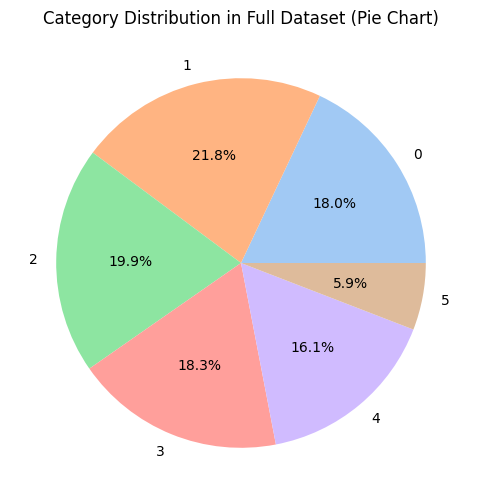

In [15]:
plt.figure(figsize=(6, 6))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title("Category Distribution in Full Dataset (Pie Chart)")
plt.show()

## Training & Evaluating

In [4]:
device = 'cuda' if pt.cuda.is_available() else 'cpu'
print(device)

cuda


In [17]:
print(df_balanced['category'].value_counts())

category
sci/tech         157826
entertainment    143670
business         132598
world            130000
sports           116488
health            42387
Name: count, dtype: int64


In [18]:
with open("label_mappings.json", "r") as f:
    mappings = json.load(f)
    label_to_id = mappings["label_to_id"]

label_counts = Counter(df_balanced['category'].values)

count_list = [label_counts[label] for label in label_to_id]
print(f"The total number of samples for each one of the categories: {count_list}")

class_counts = torch.tensor(count_list, dtype=torch.float)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() 
class_weights = class_weights.to(device)
print(f"Computed weights for the loss function according to the specified categories:{class_weights}")

The total number of samples for each one of the categories: [130000, 157826, 143670, 132598, 116488, 42387]
Computed weights for the loss function according to the specified categories:tensor([0.1267, 0.1044, 0.1147, 0.1242, 0.1414, 0.3886], device='cuda:0')


In [19]:
def train_epoch(model, data_loader, optimizer, device, class_weights):
    model.train()
    total_loss = 0
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    for batch in tqdm(data_loader):

        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss = total_loss + loss.item()


    return total_loss / len(data_loader)

def evaluate(model, data_loader, device, class_weights):
    model.eval()
    predictions = []
    actual_labels = []
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    total_loss = 0

    with pt.no_grad():
        for batch in tqdm(data_loader):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            total_loss = total_loss + loss.item()

            _, predicted = pt.max(logits, 1)
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    # print(predictions)
    accuracy = accuracy_score(actual_labels, predictions)

    return total_loss / len(data_loader), accuracy

In [20]:
model = NewsClassifier(vocab_size=tokenizer.vocab_size, num_classes=6).to(device)
path = 'bert_news_model.pt'

optimizer = AdamW(model.parameters(), lr=5e-4)

num_epochs = 5
best_accuracy = 0

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch number {epoch + 1}/{num_epochs}")

    train_loss = train_epoch(model, train_loader, optimizer, device, class_weights)
    print(f"Train loss: {train_loss:.4f}")

    val_loss, accuracy = evaluate(model, val_loader, device, class_weights)
    print(f"Validation loss: {val_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(accuracy)
    
    if best_accuracy < accuracy:
        best_accuracy = accuracy
        pt.save(model.state_dict(), path)

    print()

Epoch number 1/5


100%|████████████████████████████████████████████| 54223/54223 [07:50<00:00, 115.31it/s]


Train loss: 0.8077


100%|████████████████████████████████████████████| 18075/18075 [01:10<00:00, 257.41it/s]


Validation loss: 0.6718
Accuracy: 0.7662

Epoch number 2/5


100%|████████████████████████████████████████████| 54223/54223 [07:45<00:00, 116.45it/s]


Train loss: 0.6118


100%|████████████████████████████████████████████| 18075/18075 [01:09<00:00, 261.79it/s]


Validation loss: 0.6058
Accuracy: 0.7743

Epoch number 3/5


100%|████████████████████████████████████████████| 54223/54223 [07:46<00:00, 116.26it/s]


Train loss: 0.5638


100%|████████████████████████████████████████████| 18075/18075 [01:08<00:00, 262.94it/s]


Validation loss: 0.5965
Accuracy: 0.7806

Epoch number 4/5


100%|████████████████████████████████████████████| 54223/54223 [07:44<00:00, 116.79it/s]


Train loss: 0.5368


100%|████████████████████████████████████████████| 18075/18075 [01:12<00:00, 249.71it/s]


Validation loss: 0.6057
Accuracy: 0.7866

Epoch number 5/5


100%|████████████████████████████████████████████| 54223/54223 [07:36<00:00, 118.88it/s]


Train loss: 0.5164


100%|████████████████████████████████████████████| 18075/18075 [01:07<00:00, 266.10it/s]

Validation loss: 0.5811
Accuracy: 0.7830



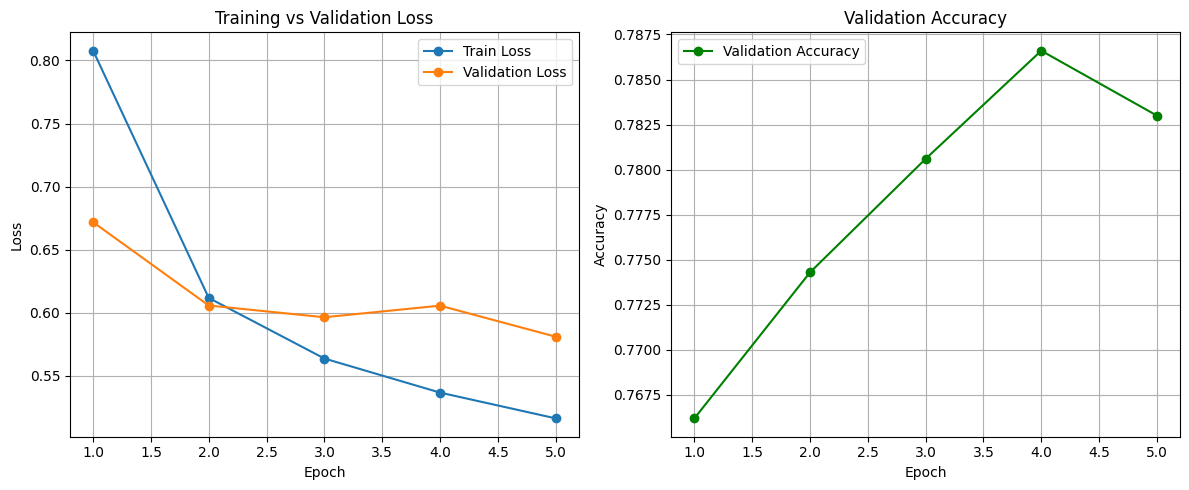

In [3]:
train_losses = [0.8077, 0.6118, 0.5638, 0.5368, 0.5164]
val_losses = [0.6718, 0.6058, 0.5965, 0.6057, 0.5811]
val_accuracies = [0.7662, 0.7743, 0.7806, 0.7866, 0.7830]
epochs = [1, 2, 3, 4, 5]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('loss_acc.jpg')
plt.show()

## Final Evaluation

In [5]:
def inference(model, tokenizer, device, text):
    model.eval()
    with pt.no_grad():
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=128,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        logits = model(input_ids=input_ids, attn_mask=attention_mask)
        _, predicted = pt.max(logits, dim=1)
 
        predicted_label = predicted.item()
        print(f"Predicted Category: {label_map[predicted_label]}")
        return predicted_label

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = NewsClassifier(vocab_size=tokenizer.vocab_size, num_classes=6).to(device)
model.load_state_dict(pt.load('bert_news_model.pt', map_location=device))
model.to(device)
model.eval()

with open("label_mappings.json", "r") as f:
    mappings = json.load(f)

label_to_id = mappings["label_to_id"]
label_map = {int(k): v for k, v in mappings["label_map"].items()} 
print("Label Map:", label_map)

text = "The company’s quarterly profits exceeded analyst expectations and shares rose 5%."
_ = inference(model, tokenizer, device, text)

Label Map: {0: 'world', 1: 'sci/tech', 2: 'entertainment', 3: 'business', 4: 'sports', 5: 'health'}
Predicted Category: business


In [17]:
def evaluate_model(model, test_loader, device, label_map):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    target_names = [label_map[i] for i in range(len(label_map))]
    
    report = classification_report(all_labels, all_preds, target_names=target_names)
    print("Classification Report:\n", report)

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    return report, cm

In [20]:
report, cm = evaluate_model(model, test_loader, device, label_map)

Classification Report:
                precision    recall  f1-score   support

        world       0.81      0.68      0.74     26048
     sci/tech       0.77      0.87      0.82     31751
entertainment       0.78      0.66      0.71     28498
     business       0.82      0.75      0.79     26673
       sports       0.85      0.97      0.90     23245
       health       0.63      0.89      0.74      8379

     accuracy                           0.79    144594
    macro avg       0.78      0.80      0.78    144594
 weighted avg       0.79      0.79      0.79    144594

Confusion Matrix:
 [[17627  1441  3459  1309  1038  1174]
 [  967 27699   768  1134   281   902]
 [ 2211  2269 18719  1604  2398  1297]
 [  720  3960   717 20045   243   988]
 [  151   167   313    74 22443    97]
 [  190   326   169   151    75  7468]]


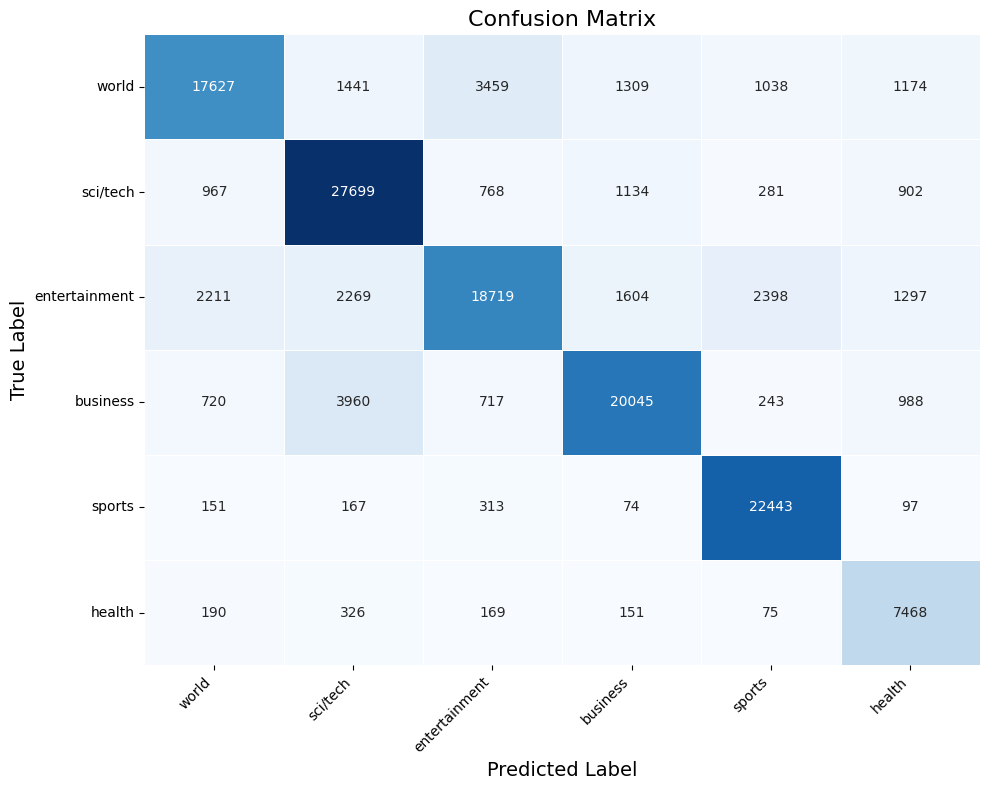

In [8]:
confusion_matrix_data = [
    [17627, 1441, 3459, 1309, 1038, 1174],
    [967, 27699, 768, 1134, 281, 902],
    [2211, 2269, 18719, 1604, 2398, 1297],
    [720, 3960, 717, 20045, 243, 988],
    [151, 167, 313, 74, 22443, 97],
    [190, 326, 169, 151, 75, 7468]
]
cm = np.array(confusion_matrix_data)

label_map = {0: 'world', 1: 'sci/tech', 2: 'entertainment', 3: 'business', 4: 'sports', 5: 'health'}

class_names = [label_map[i] for i in sorted(label_map.keys())]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            linewidths=.5, cbar=False)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('cm.pdf')
plt.show()